# Exponential Smoothing & Holt-Winters

In [332]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [333]:
# Load and set index
df = pd.read_csv('./data/weekly_customer_complaints.csv', index_col='week', parse_dates=True)
df['complaints'] = df['complaints'].str.replace(',','').astype(int)
df['discount_rate'] = df['discount_rate'].str.replace('%','').astype(float) / 100
df = df.asfreq('W-Mon')
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,1750,0.3726,1,0,0
2018-01-08,1701,0.3538,0,0,0
2018-01-15,1711,0.3622,1,0,0
2018-01-22,1443,0.3833,1,0,0
2018-01-29,1397,0.3634,0,0,0


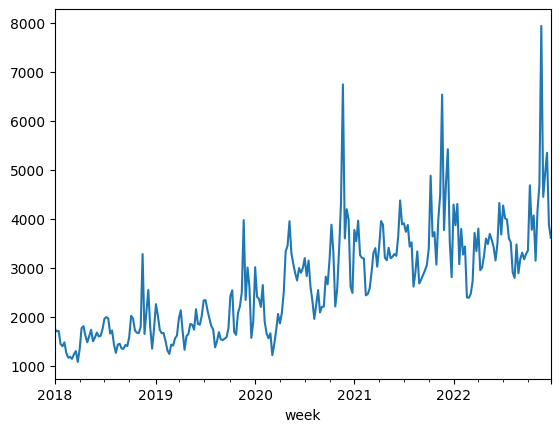

In [334]:
df['complaints'].plot()
plt.show()

## Seasonal Analysis

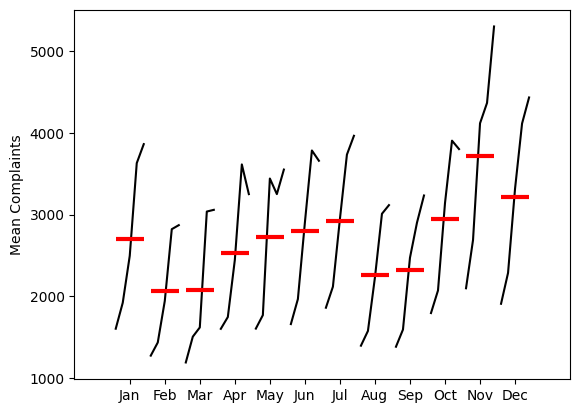

In [335]:
month_plot(df['complaints'].resample('ME').mean(), ylabel='Mean Complaints')
plt.show()

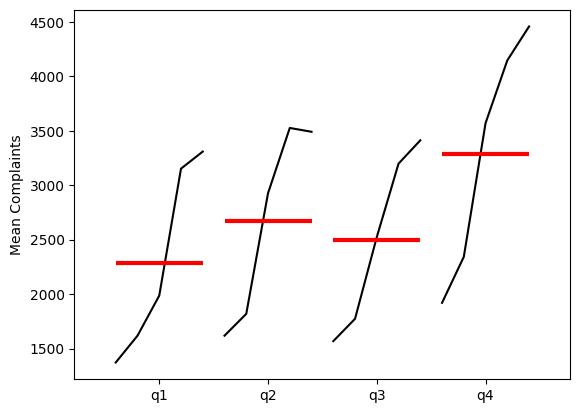

In [336]:
quarter_plot(df['complaints'].resample('QE').mean(), ylabel='Mean Complaints')
plt.show()

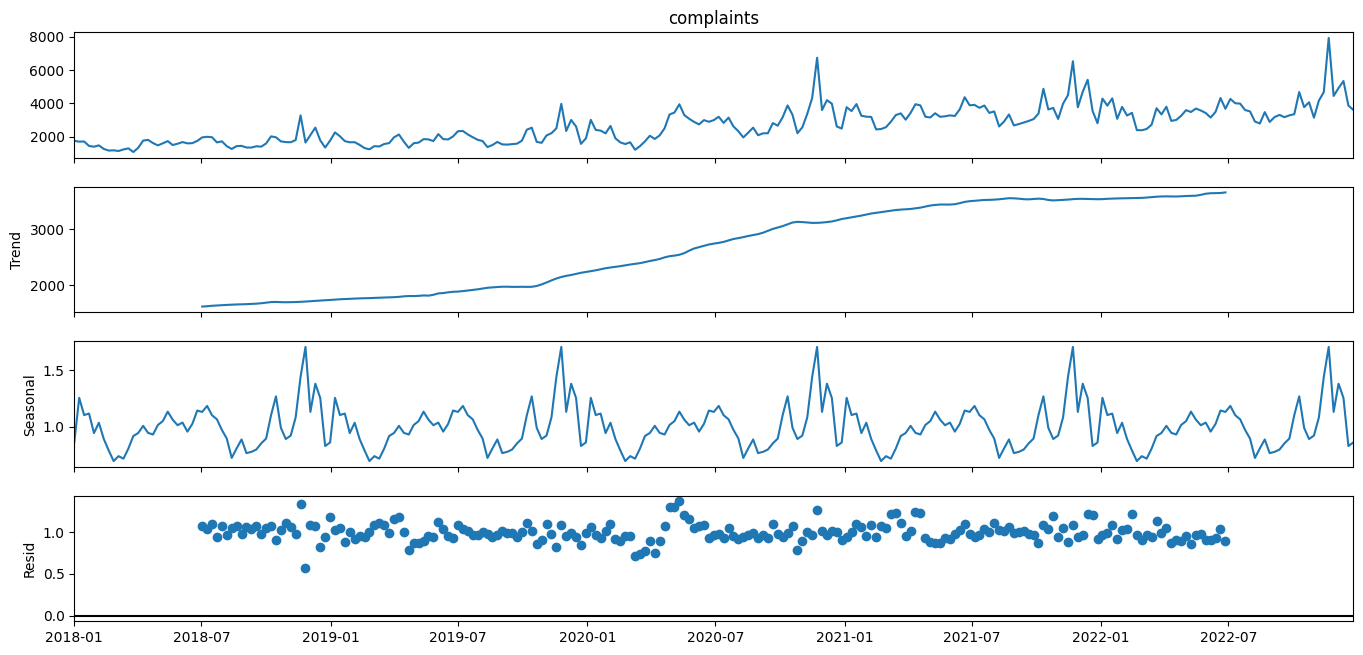

In [337]:
decompositionMul = seasonal_decompose(df['complaints'], model='multiplicative', period=52)
fig = decompositionMul.plot()
fig.set_size_inches(15, 7)
plt.show()

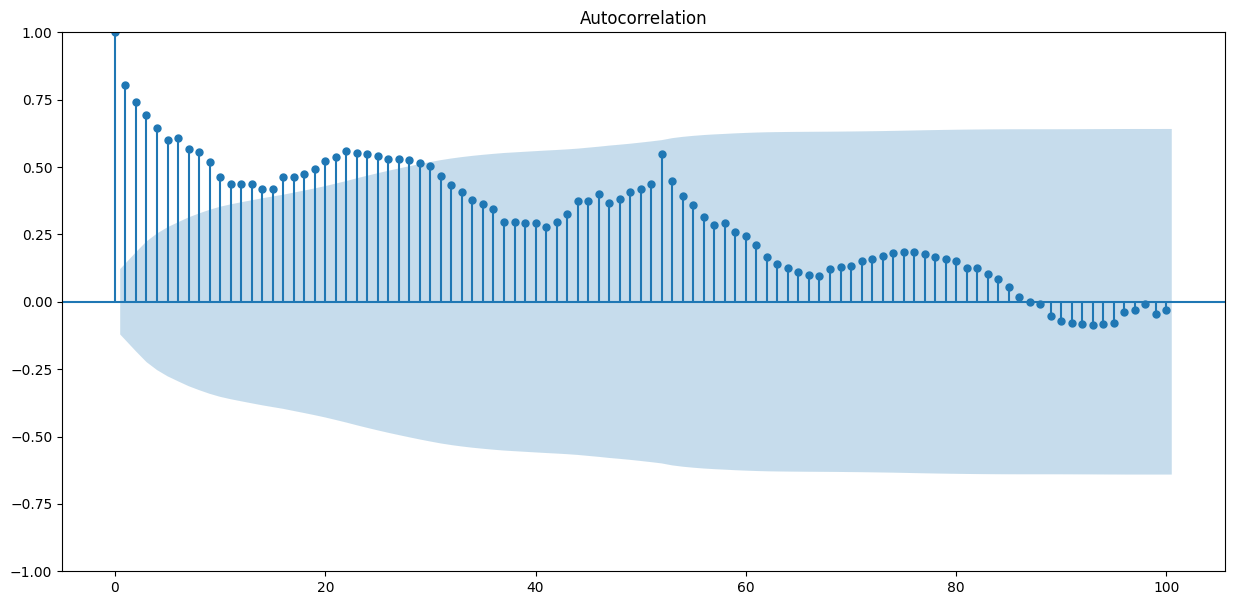

In [338]:
fig, ax = plt.subplots(figsize=(15, 7))
plot_acf(df['complaints'], ax=ax, lags=100)
plt.show()

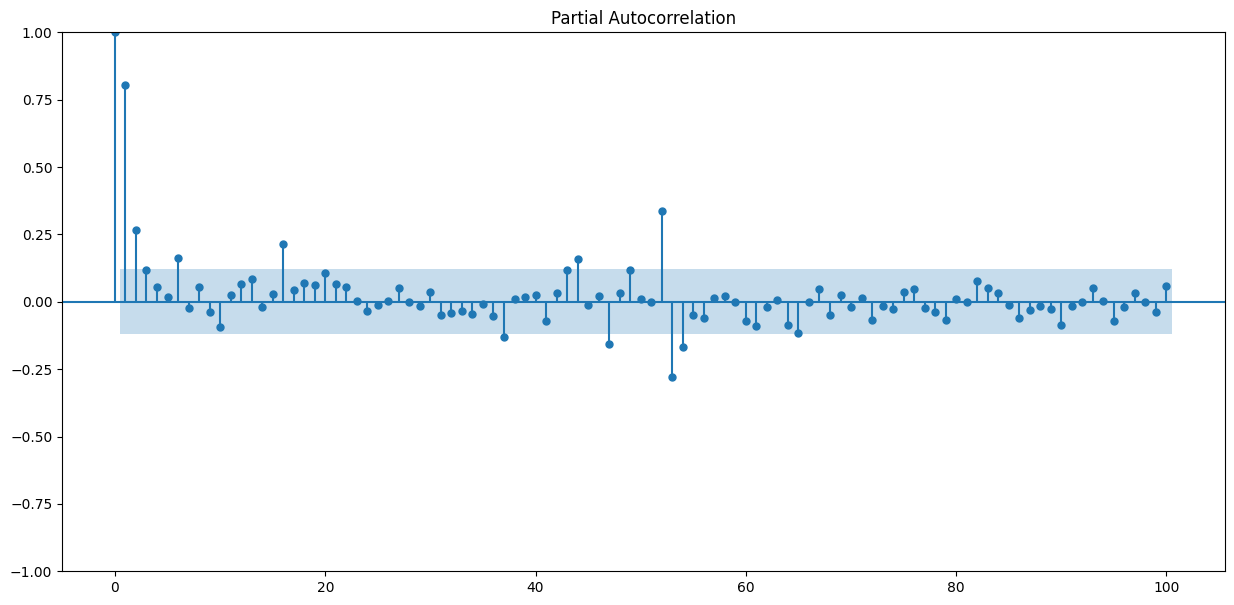

In [339]:
fig, ax = plt.subplots(figsize=(15, 7))
plot_pacf(df['complaints'], ax=ax, lags=100)
plt.show()

## Create Model for predicting next 13 weeks

In [340]:
periods = 13
# train, test = df.iloc[:-periods, 0], df.iloc[-periods:, 0]
train = df[:-periods].complaints
test = df[-periods:].complaints
print("len(train): {}, len(test): {}".format(len(train), len(test)))

len(train): 248, len(test): 13


In [341]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

### Simple Exponential Smoothing
Principle: Assigning exponentially decreasing weights to past observations, giving more importance to recent data points.


In [342]:
# Train
ses_model = SimpleExpSmoothing(train).fit()
ses_model.summary()

Dep. Variable:,complaints,No. Observations:,248
Model:,SimpleExpSmoothing,SSE,74355478.081
Optimized:,True,AIC,3131.513
Trend:,None,BIC,3138.540
Seasonal:,None,AICC,3131.678
Seasonal Periods:,None,Date:,"Tue, 25 Mar 2025"
Box-Cox:,False,Time:,17:18:43
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5097818,alpha,True
initial_level,1750.0000,l.0,False


In [343]:
# Predict
ses_pred = ses_model.forecast(steps=periods)
ses_pred

2022-10-03    3236.663468
2022-10-10    3236.663468
2022-10-17    3236.663468
2022-10-24    3236.663468
2022-10-31    3236.663468
2022-11-07    3236.663468
2022-11-14    3236.663468
2022-11-21    3236.663468
2022-11-28    3236.663468
2022-12-05    3236.663468
2022-12-12    3236.663468
2022-12-19    3236.663468
2022-12-26    3236.663468
Freq: W-MON, dtype: float64

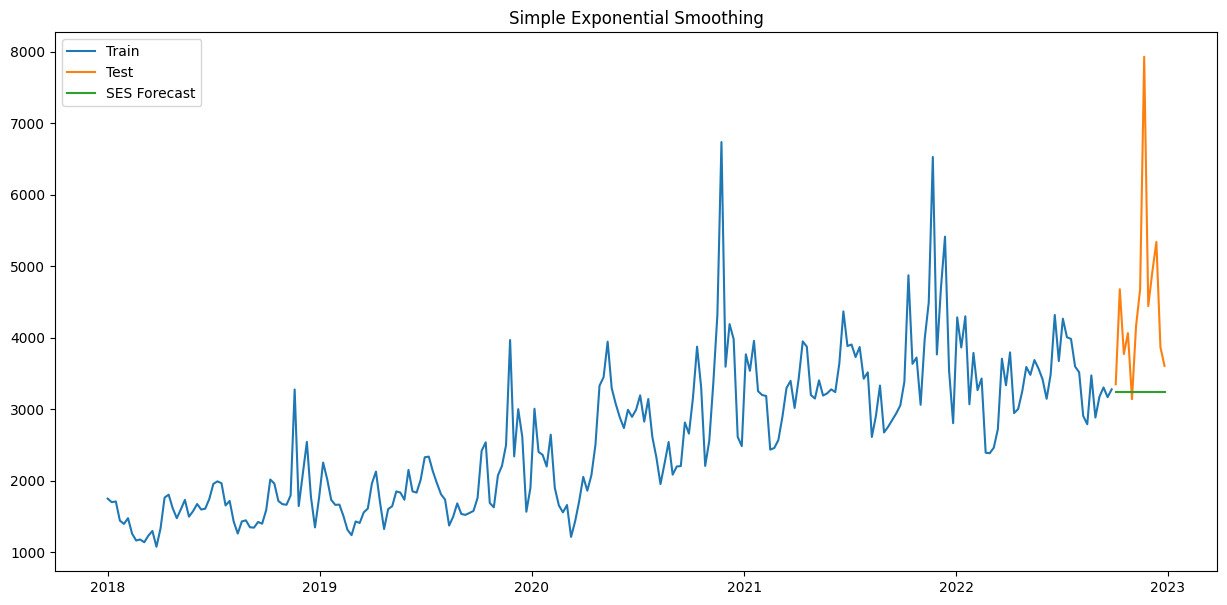

In [344]:
plt.figure(figsize=(15, 7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(ses_pred.index, ses_pred, label='SES Forecast')
plt.title('Simple Exponential Smoothing')
plt.legend()
plt.show()


## Double Exponential Smoothing
Principal: Extends Simple Exponential Smoothing by adding a component to account for trends in the data.

In [345]:
des_model = ExponentialSmoothing(train, trend='add').fit()
des_model.summary()

Dep. Variable:,complaints,No. Observations:,248
Model:,ExponentialSmoothing,SSE,75699155.590
Optimized:,True,AIC,3139.955
Trend:,Additive,BIC,3154.008
Seasonal:,None,AICC,3140.303
Seasonal Periods:,None,Date:,"Tue, 25 Mar 2025"
Box-Cox:,False,Time:,17:18:43
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5212798,alpha,True
smoothing_trend,0.0190235,beta,True


In [346]:
des_pred = des_model.forecast(steps=periods)
des_pred

2022-10-03    3234.105506
2022-10-10    3232.693127
2022-10-17    3231.280747
2022-10-24    3229.868368
2022-10-31    3228.455988
2022-11-07    3227.043609
2022-11-14    3225.631229
2022-11-21    3224.218849
2022-11-28    3222.806470
2022-12-05    3221.394090
2022-12-12    3219.981711
2022-12-19    3218.569331
2022-12-26    3217.156952
Freq: W-MON, dtype: float64

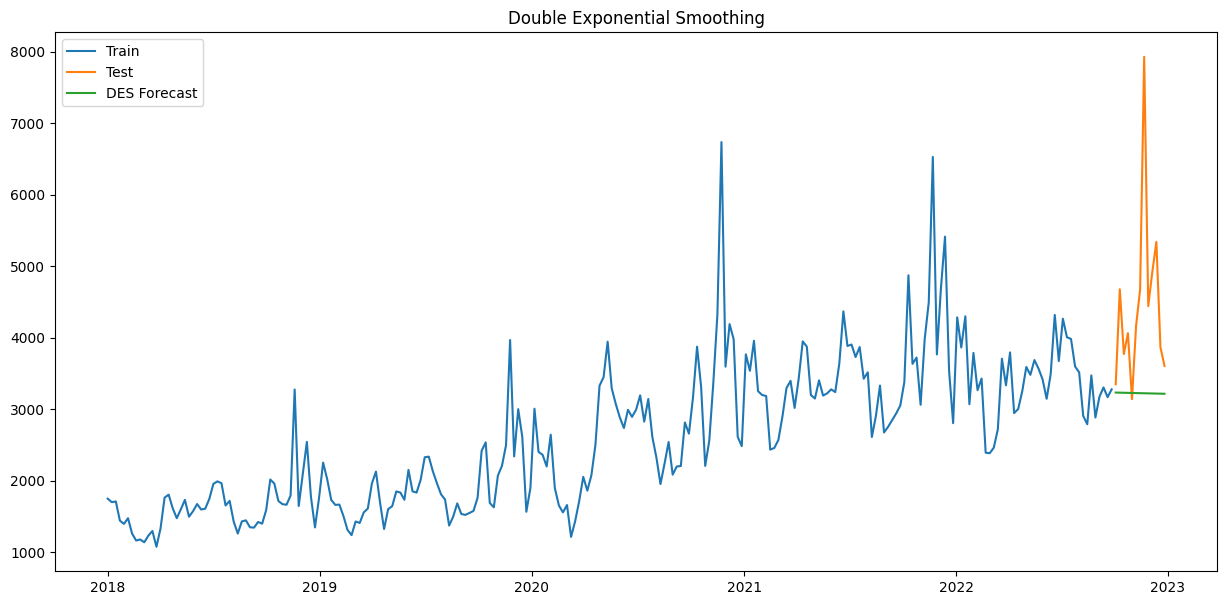

In [347]:
plt.figure(figsize=(15, 7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(des_pred.index, des_pred, label='DES Forecast')
plt.title('Double Exponential Smoothing')
plt.legend()
plt.show()

## Triple Exponential Smoothing(Holt-Winters)
Principal: extends Double Exponential Smoothing by adding a component to account for seasonality in the data.

In [348]:
tes_model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=52).fit()
tes_model.summary()

Dep. Variable:,complaints,No. Observations:,248
Model:,ExponentialSmoothing,SSE,22012274.823
Optimized:,True,AIC,2937.633
Trend:,Additive,BIC,3134.385
Seasonal:,Multiplicative,AICC,2973.845
Seasonal Periods:,52,Date:,"Tue, 25 Mar 2025"
Box-Cox:,False,Time:,17:18:43
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2171429,alpha,True
smoothing_trend,0.0001000,beta,True


In [349]:
tes_pred = tes_model.forecast(steps=periods)
tes_pred

2022-10-03    4017.738377
2022-10-10    5022.582208
2022-10-17    3903.956160
2022-10-24    3503.493210
2022-10-31    3401.504617
2022-11-07    4218.575909
2022-11-14    5303.358805
2022-11-21    7200.621705
2022-11-28    4309.556057
2022-12-05    5262.119512
2022-12-12    5234.333391
2022-12-19    3418.339801
2022-12-26    3256.657741
Freq: W-MON, dtype: float64

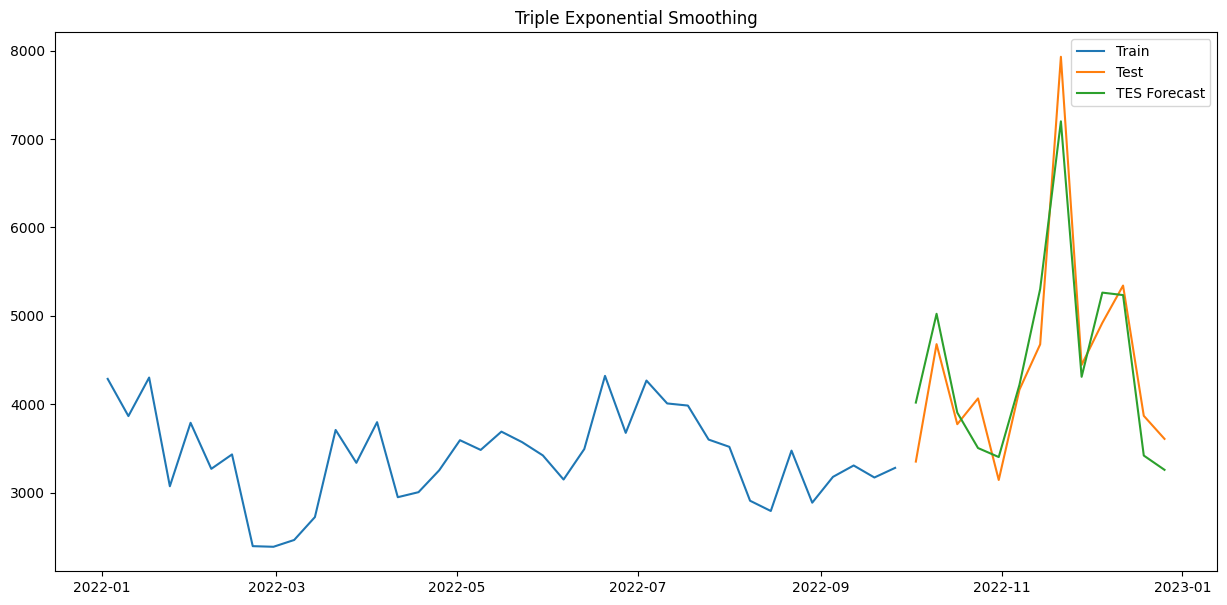

In [350]:
plt.figure(figsize=(15, 7))
plt.plot(train['2022'], label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(tes_pred.index, tes_pred, label='TES Forecast')
plt.title('Triple Exponential Smoothing')
plt.legend()
plt.show()

## Measuring Errors
RMSE is more in sensitive to outliers, and useful when outliers are more critical.
MAE is more interpretable.
MAPE is useful for percentage-based error calculation.



In [351]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def evaluate(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return rmse, mae, mape

rmse, mae, mape = evaluate(test, ses_pred)
print("Simple Exponential Smoothing Errors: rmse = {}, mae = {}, mape = {}".format(rmse, mae, mape))
rmse, mae, mape = evaluate(test, des_pred)
print("Double Exponential Smoothing Errors: rmse = {}, mae = {}, mape = {}".format(rmse, mae, mape))
rmse, mae, mape = evaluate(test, tes_pred)
print("Triple Exponential Smoothing Errors: rmse = {}, mae = {}, mape = {}".format(rmse, mae, mape))


Simple Exponential Smoothing Errors: rmse = 1694.0329074642964, mae = 1236.5155267773525, mape = 0.2395788803381615
Double Exponential Smoothing Errors: rmse = 1702.8265373958789, mae = 1246.2850768765036, mape = 0.2417147772774502
Triple Exponential Smoothing Errors: rmse = 426.4440331038322, mae = 366.0641295358559, mape = 0.08466414365148042


## Predict

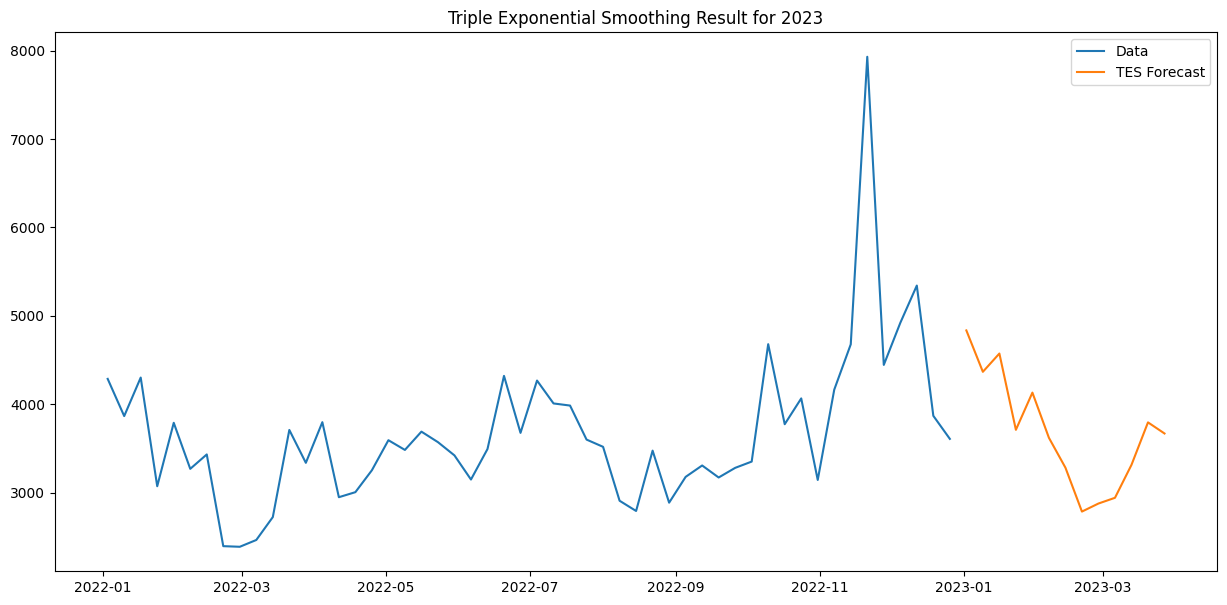

In [352]:
# Train with full data
tes_model = ExponentialSmoothing(df.complaints, trend='add', seasonal='mul', seasonal_periods=52).fit()
tes_pred_next = tes_model.forecast(steps=periods)
plt.figure(figsize=(15, 7))
plt.plot(df.complaints['2022'], label='Data')
plt.plot(tes_pred_next.index, tes_pred_next, label='TES Forecast')
plt.title('Triple Exponential Smoothing Result for 2023')
plt.legend()
plt.show()